<a href="https://colab.research.google.com/github/shubhamkoul007/Acquire-Valued-Shopper-Challenge-Team1-TDL/blob/main/CLV_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [42]:
df = pd.read_csv('online_retail_II.csv' )

df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [44]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [45]:
df.rename( columns ={'Customer ID': 'CustomerID' , 'Price' : 'UnitPrice'} , inplace= True  )

In [46]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     243007
Country             0
dtype: int64

In [47]:
#Removing all customer id's with Null Value
df=df[pd.notnull(df['CustomerID'])]

#Removing all the returned items(Quantity less than equal to 0)
df=df[df['Quantity']>0]
df['Sales'] = df['Quantity'] * df['UnitPrice']
df[df['CustomerID']==12347]['Sales'].sum()#this monetary value does not match with the monetary value that we get after summary_from_transaction_data


5633.320000000001

In [50]:
df['CustomerID'].nunique()

5881

In [48]:
!pip install lifetimes

     |████████████████████████████████| 593kB 3.4MB/s 


In [49]:
from lifetimes.plotting import *
from lifetimes.utils import *
data = summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate', monetary_value_col='Sales', observation_period_end='2011-12-10')
data1 = data.copy()
data2 = data.copy()
data.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,7.0,400.0,726.0,11066.637143
12347.0,7.0,402.0,405.0,717.398571
12348.0,4.0,363.0,439.0,449.310000
12349.0,3.0,571.0,590.0,1120.056667
12350.0,0.0,0.0,311.0,0.000000


In [51]:
import time
start=time.time()
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data1['frequency'], data1['recency'], data1['T'])
#print(bgf)

end =time.time()
print("TIme elapsed :",end-start,"seconds")

TIme elapsed : 0.2754700183868408 seconds


In [52]:
import time
start=time.time()
from lifetimes import ParetoNBDFitter
pareto = ParetoNBDFitter(penalizer_coef=0.0)
pareto.fit(data1['frequency'], data1['recency'], data1['T'])
#print(bgf)

end =time.time()
print("TIme elapsed :",end-start,"seconds")


TIme elapsed : 5.685681104660034 seconds


In [53]:
import time
start=time.time()
from lifetimes import ModifiedBetaGeoFitter
pareto = ModifiedBetaGeoFitter(penalizer_coef=0.0)
pareto.fit(data1['frequency'], data1['recency'], data1['T'])
#print(bgf)

end =time.time()
print("TIme elapsed :",end-start,"seconds")


TIme elapsed : 0.2496628761291504 seconds


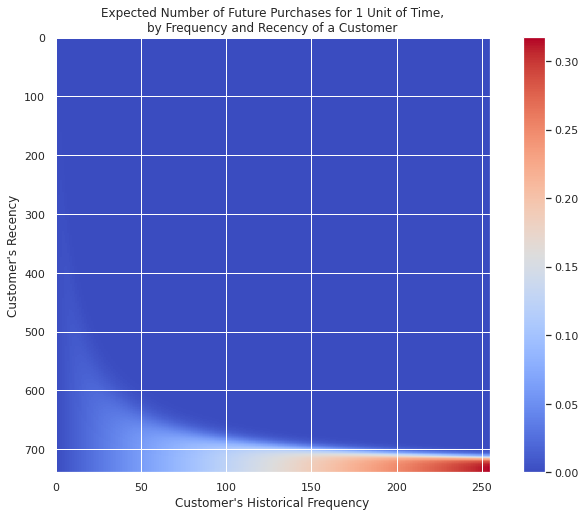

In [54]:
import seaborn as sns
sns.set_palette("husl")
sns.set(rc={'image.cmap':'coolwarm'})
%matplotlib inline
from lifetimes.plotting import plot_frequency_recency_matrix

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

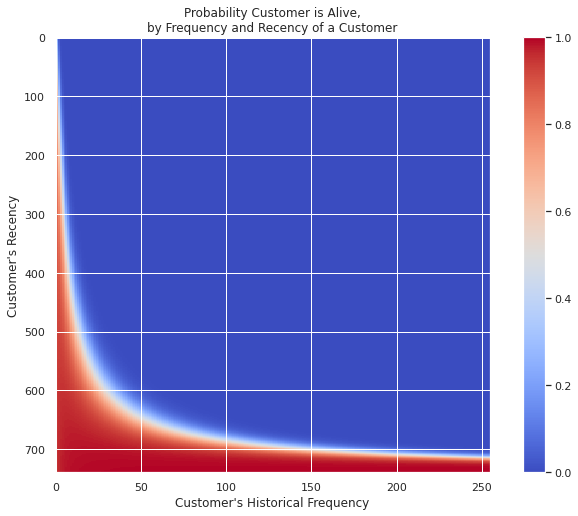

In [55]:
from lifetimes.plotting import plot_probability_alive_matrix
fig =plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

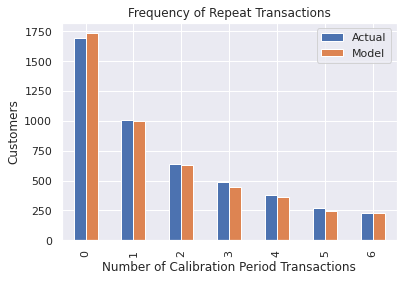

In [56]:
#Calibration Period = Training Set 
#Holdout Period = Testing Set

from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

#Here Calibration Period and Holdout Period
#are both whole observation period
#So model has overfitting

In [57]:
returning_customers_summary = data[data['frequency']>0]
print(returning_customers_summary.head())
print(len(returning_customers_summary)) 


            frequency  recency      T  monetary_value
CustomerID                                           
12346.0           7.0    400.0  726.0    11066.637143
12347.0           7.0    402.0  405.0      717.398571
12348.0           4.0    363.0  439.0      449.310000
12349.0           3.0    571.0  590.0     1120.056667
12352.0           8.0    356.0  393.0      338.261250
4189


In [58]:
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 4189 subjects, p: 2.13, q: 3.53, v: 486.53>


In [59]:
#After applying Gamma-Gamma model, now we can estimate average transaction value for each customer. 

print(ggf.conditional_expected_average_profit(
        returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value']
    ).head(10))

CustomerID
12346.0    9520.529482
12347.0     672.740683
12348.0     440.212758
12349.0     918.531323
12352.0     347.481829
12353.0     263.054511
12355.0     432.350492
12356.0     961.519741
12357.0    3059.669630
12358.0     567.432251
dtype: float64


In [60]:
#Calculate Customer Lifetime Value
returning_customers_summary['CLV'] = round(ggf.customer_lifetime_value(
    bgf, returning_customers_summary['frequency'],returning_customers_summary['recency'],
    returning_customers_summary['T'], returning_customers_summary['monetary_value'],
    time=12, discount_rate=0.01 ), 2)

returning_customers_summary.head()

,frequency,recency,T,monetary_value,CLV
CustomerID,,,,,
12346.0,7.0,400.0,726.0,11066.637143,17255.85
12347.0,7.0,402.0,405.0,717.398571,3554.63
12348.0,4.0,363.0,439.0,449.310000,1285.67
12349.0,3.0,571.0,590.0,1120.056667,1655.55
12352.0,8.0,356.0,393.0,338.261250,2106.28


In [61]:
returning_customers_summary = returning_customers_summary.reindex(columns= ['CustomerID','frequency','recency','T','monetary_value','CLV'])

returning_customers_summary['CustomerID'] = returning_customers_summary.index

returning_customers_summary.reset_index(drop=True, inplace=True)

returning_customers_summary.head(10)


,CustomerID,frequency,recency,T,monetary_value,CLV
0,12346.0,7.0,400.0,726.0,11066.637143,17255.85
1,12347.0,7.0,402.0,405.0,717.398571,3554.63
2,12348.0,4.0,363.0,439.0,449.310000,1285.67
3,12349.0,3.0,571.0,590.0,1120.056667,1655.55
4,12352.0,8.0,356.0,393.0,338.261250,2106.28
5,12353.0,1.0,204.0,409.0,89.000000,272.85
6,12355.0,1.0,353.0,568.0,459.400000,345.54
7,12356.0,5.0,402.0,425.0,1092.648000,3576.11
8,12357.0,1.0,355.0,389.0,6207.670000,3515.43
9,12358.0,4.0,730.0,732.0,614.310000,1080.24


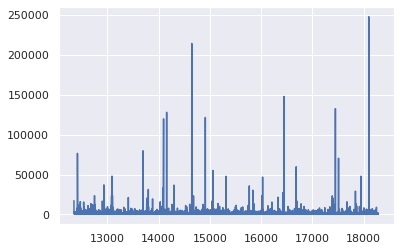

In [62]:
plt.plot( returning_customers_summary['CustomerID'] , returning_customers_summary['CLV'] ) 

plt.show()

In [63]:
sorted_returning_customers_summary = returning_customers_summary.sort_values(by='CLV', ascending=False )



In [64]:
Unique_Customers = len( sorted_returning_customers_summary )
Unique_Customers

4189

In [65]:
sorted_returning_customers_summary['rank'] = [ i for i in range(1,Unique_Customers+1)  ]

sorted_returning_customers_summary

,CustomerID,frequency,recency,T,monetary_value,CLV,rank
4074,18102.0,66.0,738.0,739.0,9189.930455,247768.22,1
1638,14646.0,90.0,736.0,738.0,5809.905333,214375.44,2
2904,16446.0,1.0,205.0,206.0,168469.600000,147748.15,3
3628,17450.0,30.0,430.0,439.0,6924.523000,132600.94,4
1277,14156.0,120.0,729.0,739.0,2607.329750,128042.86,5
...,...,...,...,...,...,...,...
2323,15633.0,12.0,222.0,732.0,346.714167,0.52,4185
1600,14590.0,18.0,308.0,733.0,161.012222,0.16,4186
521,13093.0,42.0,460.0,736.0,1284.528095,0.12,4187
3626,17448.0,17.0,148.0,646.0,830.904706,0.00,4188


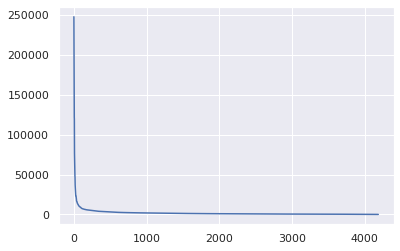

In [66]:
plt.plot( sorted_returning_customers_summary['rank'] , sorted_returning_customers_summary['CLV'] ) 

plt.show()

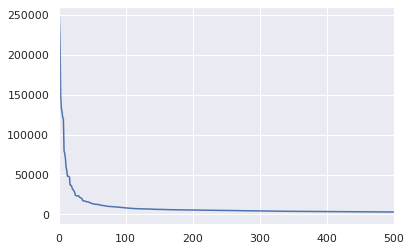

In [67]:
plt.plot( sorted_returning_customers_summary['rank'] , sorted_returning_customers_summary['CLV'] ) 

plt.xlim(0,500)
plt.show()

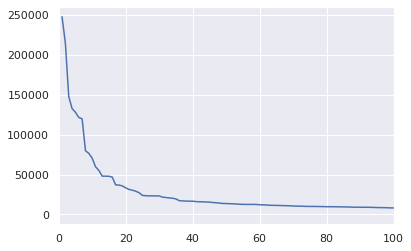

In [68]:
plt.plot( sorted_returning_customers_summary['rank'] , sorted_returning_customers_summary['CLV'] ) 

plt.xlim(0,100)

plt.show()

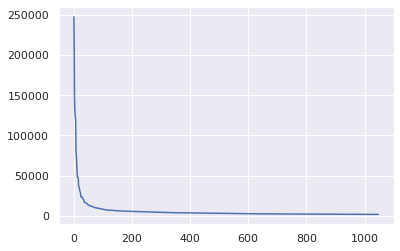

In [70]:
top_25percent_customers = sorted_returning_customers_summary[ 0 : int(Unique_Customers/4) ]

plt.plot( top_25percent_customers['rank'] , top_25percent_customers['CLV'] ) 

plt.show()

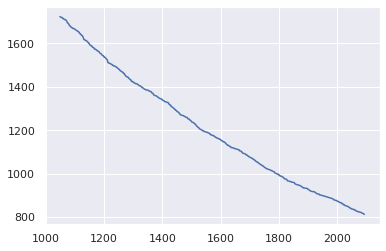

In [71]:
top_25_to_50_percent_customers = sorted_returning_customers_summary[ int(Unique_Customers/4) : int(Unique_Customers/2 )  ]

plt.plot( top_25_to_50_percent_customers['rank'] , top_25_to_50_percent_customers['CLV'] ) 

plt.show()

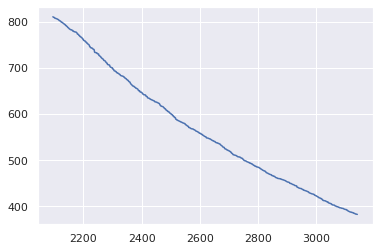

In [72]:
top_50_to_75_percent_customers = sorted_returning_customers_summary[ int(Unique_Customers/2) : int(3* Unique_Customers/4 )  ]

plt.plot( top_50_to_75_percent_customers['rank'] , top_50_to_75_percent_customers['CLV'] ) 

plt.show()

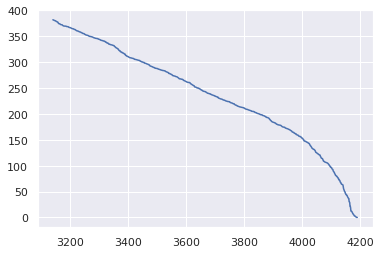

In [74]:
last_25_percent_customers = sorted_returning_customers_summary[ int(3*Unique_Customers/4) : int(Unique_Customers+1 )  ]

plt.plot( last_25_percent_customers['rank'] , last_25_percent_customers['CLV'] ) 

plt.show()

In [77]:
bgf.conditional_probability_alive_matrix(int(data1['frequency'].max()),int(data1['recency'].max()))

array([[1.00000000e+000, 2.45329650e-001, 3.50008467e-002, ...,
        8.05021687e-276, 6.38894313e-277, 5.07041791e-278],
       [1.00000000e+000, 2.50183106e-001, 3.64371037e-002, ...,
        4.21171075e-274, 3.39533113e-275, 2.73715268e-276],
       [1.00000000e+000, 2.55023816e-001, 3.79065187e-002, ...,
        2.07303024e-272, 1.69717448e-273, 1.38944269e-274],
       ...,
       [1.00000000e+000, 9.56542708e-001, 9.68739016e-001, ...,
        9.99184751e-001, 9.99185923e-001, 9.99187080e-001],
       [1.00000000e+000, 9.56629038e-001, 9.68839674e-001, ...,
        9.99405438e-001, 9.99407034e-001, 9.99408616e-001],
       [1.00000000e+000, 9.56715097e-001, 9.68939893e-001, ...,
        9.99566239e-001, 9.99567944e-001, 9.99569634e-001]])

In [79]:
recency=(sorted_returning_customers_summary['recency'].to_numpy())
freq=sorted_returning_customers_summary['frequency'].to_numpy()


rf =zip(recency,freq)
lst=[]

for r,f in rf:
    lst.append(bgf.conditional_probability_alive_matrix(int(sorted_returning_customers_summary['frequency'].max()),int(sorted_returning_customers_summary['recency'].max()))[int(r),int(f)])
print(lst)


[0.9983717094170447, 0.998493588175918, 0.7818840387976242, 9.91672190598317e-05, 0.99647378621301, 0.99940861602646, 3.604295911635626e-10, 0.9975525409496768, 0.07555171144795253, 0.9974208389156741, 0.9952260578009176, 0.9979328854919178, 0.9986411053754257, 0.9981664061921616, 0.9994404419268609, 0.9162429133183604, 0.9921995200796812, 0.9933668721532338, 0.9936732167026625, 0.09218507655061743, 0.997032424598718, 0.990816179060196, 0.9990806882140153, 0.4313973174811353, 1.1117040156503313e-06, 0.9988452184717316, 0.995917622735774, 0.9924838689357484, 0.9872053561637691, 0.997498493109653, 0.005818822724999722, 0.9979032250598242, 0.997498694150175, 0.9848026271736197, 0.8383919709771085, 0.5353457334997168, 0.09147599550287745, 2.861856130905478e-07, 0.9914527089771881, 0.9946459817179475, 0.996350148974461, 0.9961934676069543, 0.9957022613100517, 0.320987855768999, 0.9962365826318359, 0.9937938152874172, 0.9961932803721755, 0.9978619323840553, 0.9965751818209047, 0.003569704033

In [80]:
sorted_returning_customers_summary['Alive Probability'] = lst 

sorted_returning_customers_summary.head()

,CustomerID,frequency,recency,T,monetary_value,CLV,rank,Alive Probability
4074,18102.0,66.0,738.0,739.0,9189.930455,247768.22,1,0.998372
1638,14646.0,90.0,736.0,738.0,5809.905333,214375.44,2,0.998494
2904,16446.0,1.0,205.0,206.0,168469.600000,147748.15,3,0.781884
3628,17450.0,30.0,430.0,439.0,6924.523000,132600.94,4,0.000099
1277,14156.0,120.0,729.0,739.0,2607.329750,128042.86,5,0.996474


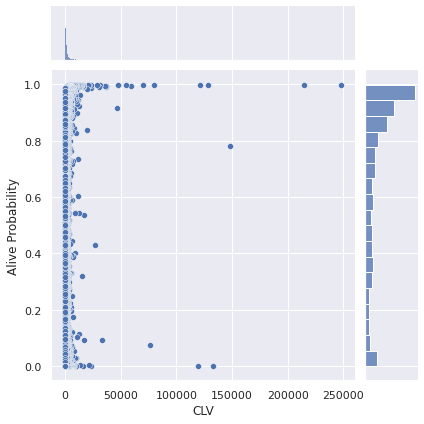

In [83]:
sns.jointplot( x = 'CLV' , y = 'Alive Probability' , data = sorted_returning_customers_summary )

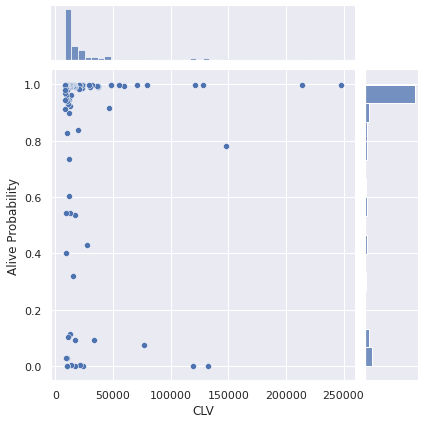

In [85]:
top_100_customers = sorted_returning_customers_summary[ 0 : 100 ]

recency=(top_100_customers['recency'].to_numpy())
freq=top_100_customers['frequency'].to_numpy()


rf =zip(recency,freq)
lst1=[]

for r,f in rf:
    lst1.append(bgf.conditional_probability_alive_matrix(int(top_100_customers['frequency'].max()),int(top_100_customers['recency'].max()))[int(r),int(f)])


top_100_customers['Alive Probability'] = lst1

sns.jointplot( x = 'CLV' , y = 'Alive Probability' , data = top_100_customers )




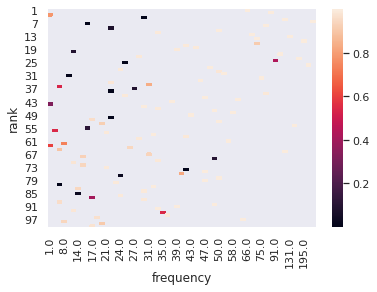

In [88]:
fp1 = top_100_customers.pivot_table(index = 'rank' , columns = 'frequency' ,values = 'Alive Probability' )  

sns.heatmap(fp1)



In [ ]:
fp = sorted_returning_customers_summary.pivot_table(index = 'rank' , columns = 'frequency' ,values = 'Alive Probability' )  

sns.heatmap(fp)

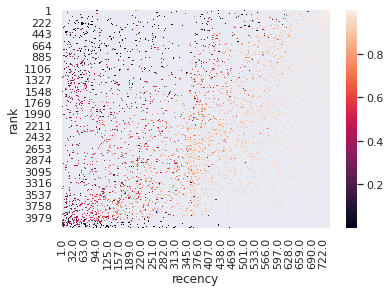

In [90]:
fp3 = sorted_returning_customers_summary.pivot_table(index = 'rank' , columns = 'recency' ,values = 'Alive Probability' )  

sns.heatmap(fp3)


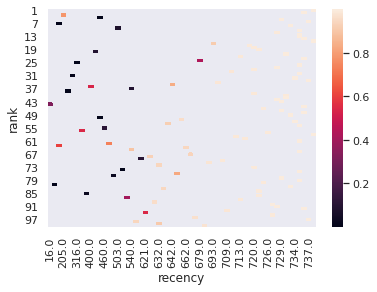

In [91]:
fp4 = top_100_customers.pivot_table(index = 'rank' , columns = 'recency' ,values = 'Alive Probability' )  

sns.heatmap(fp4)

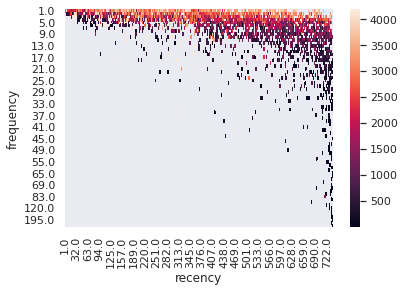

In [93]:
fp5 = sorted_returning_customers_summary.pivot_table(index = 'frequency' , columns = 'recency' ,values = 'rank' )  

sns.heatmap(fp5)


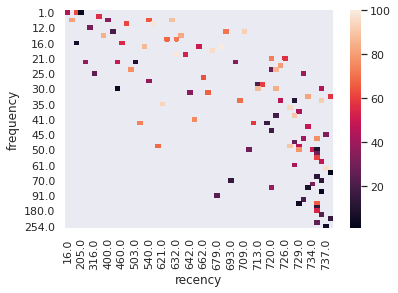

In [95]:
fp6 = top_100_customers.pivot_table(index = 'frequency' , columns = 'recency' ,values = 'rank' )  

sns.heatmap(fp6)



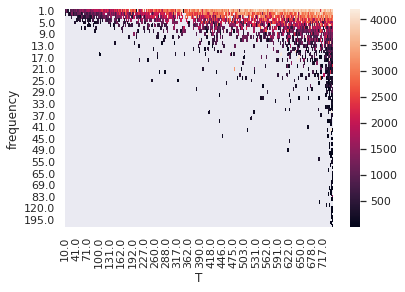

In [96]:
fp7 = sorted_returning_customers_summary.pivot_table(index = 'frequency' , columns = 'T' ,values = 'rank' )  

sns.heatmap(fp7)

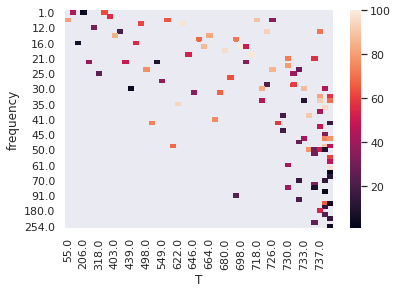

In [97]:
fp8 = top_100_customers.pivot_table(index = 'frequency' , columns = 'T' ,values = 'rank' )  

sns.heatmap(fp8)



In [102]:
insight = sorted_returning_customers_summary[ ['CLV' , 'frequency' , 'recency' , 'Alive Probability'] ]

insight.corr()

,CLV,frequency,recency,Alive Probability
CLV,1.000000,0.503075,0.140502,0.024641
frequency,0.503075,1.000000,0.423618,0.149200
recency,0.140502,0.423618,1.000000,0.765579
Alive Probability,0.024641,0.149200,0.765579,1.000000
